In [1]:
import os
import sys
import numpy as np
import pandas as pd

import joblib
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import deepchem as dc
from deepchem.feat.mol_graphs import WeaveMol
from deepchem.feat import WeaveFeaturizer
from deepchem.data.datasets import NumpyDataset

%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
font = {
    'font.family': 'sans-serif',
    'font.sans-serif': 'Arial',
    'font.size': 18,
}
plt.rcParams.update(font)

sys.path.append("../data/")
from classes import families, validate_family, add_tags

model_dir = '../results/mpnn03-repeat028'
figure_dir = 'Figures'

from openeye import oechem, oedepict, oegrapheme

from IPython.display import display_png, display, HTML

# MPNN Figure

Structure of 1-Propanal to use as an example input structure.

In [2]:
mol = oechem.OEGraphMol()
oechem.OESmilesToMol(mol, "CCC=O")
oedepict.OEPrepareDepiction(mol)

dpi=300
width, height, scale = 1*dpi, 1*dpi, oedepict.OEScale_AutoScale

image = oedepict.OEImage(width, height, oechem.OETransparentColor)
opts = oedepict.OE2DMolDisplayOptions(width, height, scale)
disp = oedepict.OE2DMolDisplay(mol, opts)

oedepict.OERenderMolecule(image, disp)
oedepict.OEWriteImage(figure_dir+"/mol.pdf", image)

True

# Regression Results

In [3]:
raw_training_data = joblib.load(model_dir + '/training.joblib')
raw_testing_data = joblib.load(model_dir + '/testing.joblib')
transformers = joblib.load(model_dir + '/transformers.joblib')

transformed_data = []
for dataset in [raw_training_data, raw_testing_data]:
    for transformer in transformers:
          transformed_data.append(transformer.transform(dataset))
training_data, testing_data = tuple(transformed_data)

model = dc.models.MPNNTensorGraph(n_tasks=1)
with open(model_dir+'/model.pickle', 'rb') as fout:
    model = pickle.load(fout)
model.built = False
model.model_dir = model_dir
model.restore()

training_predictions = model.predict(training_data)
testing_predictions = model.predict(testing_data)
untransformed_data = []
for dataset in [training_predictions, testing_predictions]:
    untransformed_data.append(transformer.untransform(dataset))

raw_training_predictions, raw_testing_predictions = tuple(untransformed_data)

/localdata0/Code/Python/anaconda3/envs/deepchem_py3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Restoring parameters from ../results/mpnn03-repeat028/model-500


In [4]:
pred_threshold = 4
font = {
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',
    'font.size': 9,
}
plt.rcParams.update(font)
figsize = (3.5, 2)

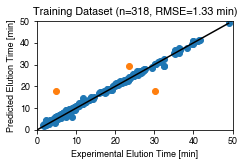

In [5]:
plt.rcParams.update(font)
y_expt = raw_training_data.y
y_expt = y_expt.flatten()
y_pred = raw_training_predictions
y_pred = y_pred.flatten()

good_predictions = np.abs(y_pred - y_expt) < pred_threshold
bad_predictions = np.abs(y_pred - y_expt) > pred_threshold

fig1 = plt.figure(figsize=figsize)
ax1 = fig1.add_subplot(111)
ax1.plot(y_expt[good_predictions], y_pred[good_predictions], color='tab:blue', marker='o', linestyle='None')
ax1.plot(y_expt[bad_predictions], y_pred[bad_predictions], color='tab:orange', marker='o', linestyle='None')
ax1.plot(np.arange(0, 50), np.arange(0, 50), 'k-')
ax1.set_xlabel("Experimental Elution Time [min]")
ax1.set_ylabel("Predicted Elution Time [min]")
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])
ax1.set_title("Training Dataset (n={:d}, RMSE={:.2f} min)".format(
    len(y_expt), 
    np.sqrt(mean_squared_error(y_expt, y_pred))))
#fig1.savefig(model.model_dir + "/Training_Performance.png")
fig1.savefig(figure_dir + "/training_performance.pdf")

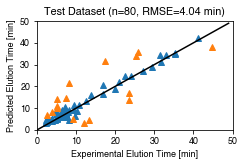

In [6]:
y_expt = raw_testing_data.y
y_expt = y_expt.flatten()
y_pred = raw_testing_predictions
y_pred = y_pred.flatten()

good_predictions = np.abs(y_pred - y_expt) < pred_threshold
bad_predictions = np.abs(y_pred - y_expt) > pred_threshold

fig1 = plt.figure(figsize=figsize)
ax1 = fig1.add_subplot(111)
ax1.plot(y_expt[good_predictions], y_pred[good_predictions], color='tab:blue', marker='^', linestyle='None')
ax1.plot(y_expt[bad_predictions], y_pred[bad_predictions], color='tab:orange', marker='^', linestyle='None')

ax1.plot(np.arange(0, 50), np.arange(0, 50), 'k-')
ax1.set_xlabel("Experimental Elution Time [min]")
ax1.set_ylabel("Predicted Elution Time [min]")
ax1.set_xlim([0, 50])
ax1.set_ylim([0, 50])
ax1.set_title("Test Dataset (n={:d}, RMSE={:.2f} min)".format(
    len(y_expt), 
    np.sqrt(mean_squared_error(y_expt, y_pred))))
#fig1.savefig(model.model_dir + "/Test_Performance.png")
fig1.savefig(figure_dir + "/test_performance.pdf")

# Model Performance by Class

In [7]:
output_dataset = pd.read_csv(model_dir + '/predictions.csv', index_col=0)
output_dataset.head()

,CNAME,smiles,neg RT (min),predicted neg RT (min),error neg RT (min),split,id_num,indole,phenyl,pyruvate,...,dicarboxylic acid,tricarboxylic acid,"sugar, amino sugar, sugar carboxylic acid",sugar monophosphate,sugar diphosphate,sugar diphosphate sugar,sugar diphosphate sugar phosphate,isomers,small but systematic changes,small and significant changes
0,SELENOMETHIONINE,C[Se]CCC(C(=O)O)N,6.25,7.775598,1.525598,test,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,L-LYSINE,C(CCCN)C(C(=O)O)N,22.99,23.589376,0.599376,train,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,L-ORNITHINE,C(CCN)C(C(=O)O)N,23.52,24.022165,0.502165,train,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DL-5-HYDROXYLYSINE,C(CCC(CN)O)(C(=O)O)N,23.54,24.269242,0.729242,train,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,NORADRENALINE,C(CN)(c1cc(c(cc1)O)O)O,24.13,24.407094,0.277094,train,4,0,1,0,...,0,0,0,0,0,0,0,14,0,0


In [8]:
def plot_predictions(data_subset):
    y_expt_train = data_subset[data_subset['split'] == 'train']['neg RT (min)'].values
    y_pred_train = data_subset[data_subset['split'] == 'train']['predicted neg RT (min)'].values
    good_predictions_train = np.abs(y_pred_train - y_expt_train) < pred_threshold
    bad_predictions_train = np.abs(y_pred_train - y_expt_train) > pred_threshold
    y_expt_test = data_subset[data_subset['split'] == 'test']['neg RT (min)'].values
    y_pred_test = data_subset[data_subset['split'] == 'test']['predicted neg RT (min)'].values
    good_predictions_test = np.abs(y_pred_test - y_expt_test) < pred_threshold
    bad_predictions_test = np.abs(y_pred_test - y_expt_test) > pred_threshold
    
    font = {
        'font.family': 'sans-serif',
        'font.sans-serif': 'Helvetica',
        'font.size': 9,
    }
    plt.rcParams.update(font)
    fig1 = plt.figure(figsize=(2.0, 1.6))
    ax1 = fig1.add_subplot(111)
    ax1.plot(y_expt_train[good_predictions_train], y_pred_train[good_predictions_train], 
             color='tab:blue', marker='o', linestyle='None')
    ax1.plot(y_expt_train[bad_predictions_train], y_pred_train[bad_predictions_train], 
             color='tab:orange', marker='o', linestyle='None')
    ax1.plot(y_expt_test[good_predictions_test], y_pred_test[good_predictions_test], 
             color='tab:blue', marker='^', linestyle='None')
    ax1.plot(y_expt_test[bad_predictions_test], y_pred_test[bad_predictions_test], 
             color='tab:orange', marker='^', linestyle='None')

    ax1.plot(np.arange(0, 50), np.arange(0, 50), 'k-')
    ax1.set_xlabel("Expt. [min]")
    ax1.set_ylabel("Pred. [min]")
    ax1.set_xlim([0, 50])
    ax1.set_ylim([0, 50])
    return fig1, ax1

## Sugars

66 items found:


,CNAME,smiles,neg RT (min),predicted neg RT (min),error neg RT (min),split,id_num,indole,phenyl,pyruvate,maleic acid,pyridoxate,mannosamine,naphthoate,cys,methionine,quionone,unexpected,N-methyl-amino-acid,sucrose like,nicotinamide,sugar-P,uridine-P,guanosine-P,cytidine-P,thymidine-P,adenosine-P,xanthosine-P,adenine-P,xanthine-P,uracil-P,nucleobases like,monocarboxylic acid,dicarboxylic acid,tricarboxylic acid,"sugar, amino sugar, sugar carboxylic acid",sugar monophosphate,sugar diphosphate,sugar diphosphate sugar,sugar diphosphate sugar phosphate,isomers,small but systematic changes,small and significant changes
23,THIOPURINE S-METHYLETHER,c1nc2ncnc(SC)c2[nH]1,23.41,23.144806,-0.265194,train,23,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9,0,0,0,0,0,0,0
25,D-(+)-GLUCOSAMINE,C(O)C(O)C(O)C(O)C(N)C=O,5.49,5.605343,0.115343,train,25,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,15,0
56,D-(+)-TREHALOSE,C1(C(C(C(C(CO)O1)O)O)O)OC1C(C(C(C(CO)O1)O)O)O,9.39,8.984701,-0.405299,test,56,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,22,0
59,MELIBIOSE,C(OC1C(O)C(O)C(O)C(CO)O1)C1C(O)C(O)C(O)C(O)O1,9.12,9.461171,0.341171,train,59,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,20,0,0,0,0,0,22,0
102,GUANINE,c1nc2c(c(=O)nc(N)[nH]2)[nH]1,7.69,7.537680,-0.152320,train,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0


RMSE: 0.11


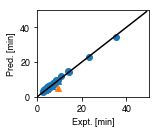

In [9]:
subset_name = 'sugars'
data_subset = output_dataset[(output_dataset['sugar, amino sugar, sugar carboxylic acid'] != 0)
                            ]
print(f"{len(data_subset)} items found:")
display(HTML(data_subset.head().to_html()))

fig1, ax1 = plot_predictions(data_subset)
fig1.savefig(figure_dir + f"/{subset_name:s}_performance.pdf")
RMSE = np.linalg.norm(data_subset['error neg RT (min)'].values)/len(data_subset)
print(f"RMSE: {RMSE:.2f}")

## Sugar Phosphates

45 items found:


,CNAME,smiles,neg RT (min),predicted neg RT (min),error neg RT (min),split,id_num,indole,phenyl,pyruvate,maleic acid,pyridoxate,mannosamine,naphthoate,cys,methionine,quionone,unexpected,N-methyl-amino-acid,sucrose like,nicotinamide,sugar-P,uridine-P,guanosine-P,cytidine-P,thymidine-P,adenosine-P,xanthosine-P,adenine-P,xanthine-P,uracil-P,nucleobases like,monocarboxylic acid,dicarboxylic acid,tricarboxylic acid,"sugar, amino sugar, sugar carboxylic acid",sugar monophosphate,sugar diphosphate,sugar diphosphate sugar,sugar diphosphate sugar phosphate,isomers,small but systematic changes,small and significant changes
61,D-GLUCOSAMINE 6-PHOSPHATE,C(C(C(C=O)N)O)(C(COP(=O)(O)O)O)O,25.81,25.280936,-0.529064,train,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
94,"FRUCTOSE 1,6-BIPHOSPHATE",C(C(C(COP(=O)([O-])[O-])O)O)(C(COP(=O)([O-])[O...,39.57,39.587376,0.017376,train,94,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
99,XANTHOSINE 5'-MONOPHOSPHATE,O=c1c2c(n(cn2)C2OC(C(C2O)O)COP(=O)(O)O)[nH]c([...,32.37,32.334007,-0.035993,train,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0
124,Guanosine 5'-Monophosphate Hydrate,c1nc2c(=O)nc(N)[nH]c2n1C1C(O)C(O)C(COP(=O)(O)O)O1,30.46,30.423308,-0.036692,train,124,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0
131,2'-DEOXYGUANOSINE 5'-MONOPHOSPHATE,c1nc2c(=O)nc(N)[nH]c2n1C1CC(O)C(COP(=O)(O)O)O1,29.49,28.513854,-0.976146,train,131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,21,0,0


RMSE: 0.34


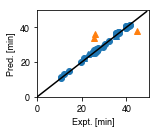

In [10]:
subset_name = 'sugar_phosphates'
data_subset = output_dataset[(output_dataset['sugar monophosphate'] != 0) |
                             (output_dataset['sugar diphosphate'] != 0) |
                             (output_dataset['sugar diphosphate sugar'] != 0) |
                             (output_dataset['sugar diphosphate sugar phosphate'] != 0)
                            ]
print(f"{len(data_subset)} items found:")
display(HTML(data_subset.head().to_html()))

fig1, ax1 = plot_predictions(data_subset)
fig1.savefig(figure_dir + f"/{subset_name:s}_performance.pdf")
RMSE = np.linalg.norm(data_subset['error neg RT (min)'].values)/len(data_subset)
print(f"RMSE: {RMSE:.2f}")

## Carboxylic Acids

183 items found:


,CNAME,smiles,neg RT (min),predicted neg RT (min),error neg RT (min),split,id_num,indole,phenyl,pyruvate,maleic acid,pyridoxate,mannosamine,naphthoate,cys,methionine,quionone,unexpected,N-methyl-amino-acid,sucrose like,nicotinamide,sugar-P,uridine-P,guanosine-P,cytidine-P,thymidine-P,adenosine-P,xanthosine-P,adenine-P,xanthine-P,uracil-P,nucleobases like,monocarboxylic acid,dicarboxylic acid,tricarboxylic acid,"sugar, amino sugar, sugar carboxylic acid",sugar monophosphate,sugar diphosphate,sugar diphosphate sugar,sugar diphosphate sugar phosphate,isomers,small but systematic changes,small and significant changes
1,L-LYSINE,C(CCCN)C(C(=O)O)N,22.99,23.589376,0.599376,train,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,0,0,0
2,L-ORNITHINE,C(CCN)C(C(=O)O)N,23.52,24.022165,0.502165,train,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,18,0,0,0,0,0,0,0,0,0,0
3,DL-5-HYDROXYLYSINE,C(CCC(CN)O)(C(=O)O)N,23.54,24.269242,0.729242,train,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,27,0,0,0,0,0,0,0,0,0,0
6,"3,4-DIHYDROXY-L-PHENYLALANINE",c1c(ccc(c1O)O)CC(C(=O)O)N,24.12,24.370828,0.250828,train,6,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,43,0,0,0,0,0,0,0,0,0,0
7,"LL-2,6-DIAMINOHEPTANEDIOATE",C(CCCC(C(=O)O)N)(C(=O)O)N,20.87,21.179502,0.309502,train,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0


RMSE: 0.18


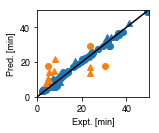

In [11]:
subset_name = 'carboxylic_acids'

data_subset = output_dataset[(output_dataset['monocarboxylic acid'] != 0) |
                             (output_dataset['dicarboxylic acid'] != 0) |
                             (output_dataset['tricarboxylic acid'] != 0)
                            ]
print(f"{len(data_subset)} items found:")
display(HTML(data_subset.head().to_html()))

fig1, ax1 = plot_predictions(data_subset)
fig1.savefig(figure_dir + f"/{subset_name:s}_performance.pdf")
RMSE = np.linalg.norm(data_subset['error neg RT (min)'].values)/len(data_subset)
print(f"RMSE: {RMSE:.2f}")

## Isomers

48 items found:


,CNAME,smiles,neg RT (min),predicted neg RT (min),error neg RT (min),split,id_num,indole,phenyl,pyruvate,maleic acid,pyridoxate,mannosamine,naphthoate,cys,methionine,quionone,unexpected,N-methyl-amino-acid,sucrose like,nicotinamide,sugar-P,uridine-P,guanosine-P,cytidine-P,thymidine-P,adenosine-P,xanthosine-P,adenine-P,xanthine-P,uracil-P,nucleobases like,monocarboxylic acid,dicarboxylic acid,tricarboxylic acid,"sugar, amino sugar, sugar carboxylic acid",sugar monophosphate,sugar diphosphate,sugar diphosphate sugar,sugar diphosphate sugar phosphate,isomers,small but systematic changes,small and significant changes
4,NORADRENALINE,C(CN)(c1cc(c(cc1)O)O)O,24.13,24.407094,0.277094,train,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0
11,CAFFEATE,c1c(c(ccc1C=CC(=O)O)O)O,23.49,13.794008,-9.695992,test,11,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,0,0,0,0,0,0,0,17,0,0
15,"3,4-DIHYDROXYBENZOATE",c1c(ccc(c1O)O)C(=O)O,23.50,16.962535,-6.537465,test,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,0,0,0,0,0,0,0,11,0,0
20,ACETOIN,CC(O)C(C)=O,7.43,5.687037,-1.742963,test,20,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0
31,FUMARATE,O=C(O)C=CC(=O)O,30.23,17.975943,-12.254057,train,31,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,3,0,0


RMSE: 0.53


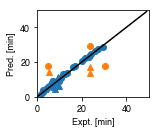

In [12]:
subset_name = 'isomers'

data_subset = output_dataset[(output_dataset['isomers'] != 0)
                            ]
print(f"{len(data_subset)} items found:")
display(HTML(data_subset.head().to_html()))

fig1, ax1 = plot_predictions(data_subset)
fig1.savefig(figure_dir + f"/{subset_name:s}_performance.pdf")
RMSE = np.linalg.norm(data_subset['error neg RT (min)'].values)/len(data_subset)
print(f"RMSE: {RMSE:.2f}")